In [8]:
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 421.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 999.8 kB/s eta 0:00:00:010m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 1.1 MB/s eta 0:00:0000:010m00:02


In [2]:
path_to_file = 'BaseCom9Nov23.RData'
result = pyreadr.read_r(path_to_file)
df = result["com"]

In [3]:
# Pretraitement des donnees
data_pannels = pd.read_pickle("data_pannels.pkl")
data_pannels.columns
print(df.columns)
df.rename(columns={'date': 'Date'}, inplace=True)
df['idEntreprise'] = df['idEntreprise'].astype(int)
df[["idEntreprise","mv","Date"]]
data_pannels['Date'] = pd.to_datetime(data_pannels['Date'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m') 
data_pannels_finance = pd.merge(data_pannels, df[["idEntreprise","Date","mv"]], on=['idEntreprise', 'Date'], how='left')
data_pannels_finance.sort_values(by=['idEntreprise', 'Date'], inplace=True)
data_pannels_finance.dropna(subset=['mv', 'score_comm'], inplace=True)
data_pannels_finance['ESG'] = data_pannels_finance['ESG'].str.replace(',', '.').astype(float)
data_pannels_finance['Date'] = pd.to_datetime(data_pannels_finance['Date'])

# Final dataset
data_pannels_finance

Index(['idEntreprise', 'date', 'com', 'y', 'm', 'my', 'ISIN', 'Company',
       'Sect', 'Country', 'Zone', 'fcomp', 'fcomn', 'esge', 'esge1', 'esge2',
       'esge3', 'con', 'con1', 'con2', 'con3', 'fcon1', 'fcon2', 'fcon3',
       'comb', 'CUSIP', 'ret', 'beta12', 'mv', 'bm', 'de_ratio', 'roe'],
      dtype='object')


,idEntreprise,Date,score_comm,ESG,PFL,Diff_z,Controverse,GICS industry group,GICS sub-industry,mv
0,1,2009-01-01,-0.017343,60.866464,100.000000,5.475597,29.837788,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,1.072735e+08
1,1,2009-02-01,-0.010151,61.046910,100.000000,5.339223,23.870230,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,8.303427e+07
2,1,2009-03-01,-0.010089,61.223748,100.000000,5.534291,19.096184,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,9.186200e+07
3,1,2009-04-01,-0.018865,60.841493,100.000000,5.639993,26.388059,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,9.010839e+07
4,1,2009-05-01,-0.019249,60.590206,100.000000,5.892612,43.332669,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,1.025018e+08
...,...,...,...,...,...,...,...,...,...,...
15987,8984,2022-08-01,-0.125280,65.950223,83.333333,-0.182129,0.000000,Materials,Specialty Chemicals,3.985769e+06
15988,8984,2022-09-01,-0.123934,65.814552,83.333333,-0.185574,0.000000,Materials,Specialty Chemicals,2.755391e+06
15989,8984,2022-10-01,-0.125492,65.681594,83.333333,-0.185418,0.000000,Materials,Specialty Chemicals,3.136417e+06
15990,8984,2022-11-01,-0.123957,66.662407,83.333333,-0.186469,0.000000,Materials,Specialty Chemicals,3.147572e+06


In [4]:
data_pannels_finance['idEntreprise'].unique() # = 37, pas terrible mais on fera
                                              # avec, c'est juste pour la demarche

array([   1,    4,   32,   48,   51,  106,  107,  158,  159,  162,  163,
        173,  176,  257,  268,  269,  274,  289,  359,  386,  412,  417,
        467,  473,  823,  921, 1057, 1190, 1671, 1881, 2052, 6635, 6640,
       6652, 6653, 6654, 8984])

Descriptive Statistics:
                  mv   score_comm
count  6.158000e+03  6158.000000
mean   9.641762e+07    -0.149742
std    1.761630e+08     0.283007
min    7.539167e+04    -1.739980
25%    1.553517e+07    -0.318743
50%    4.597874e+07    -0.170119
75%    1.286253e+08    -0.049658
max    2.525084e+09     1.025271


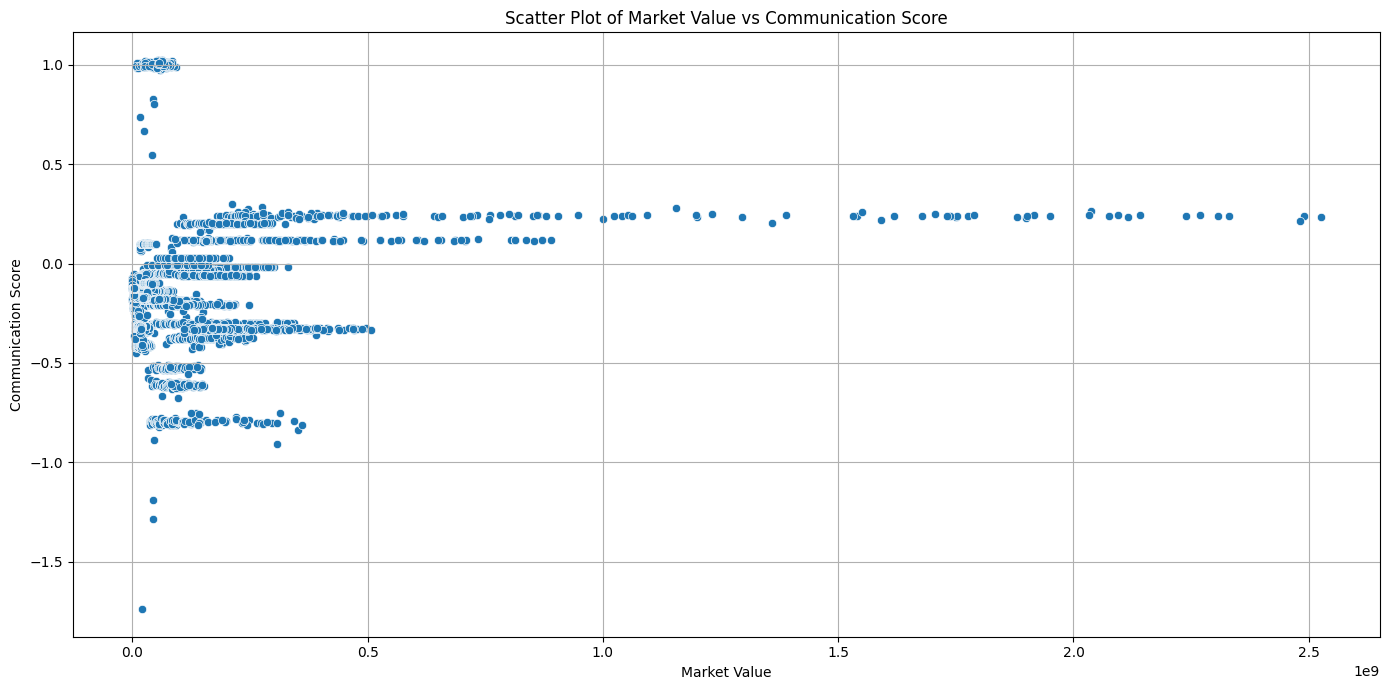

In [6]:
# Calculate descriptive statistics for 'mv' and 'score_comm'
descriptive_stats = data_pannels_finance[['mv', 'score_comm']].describe()
print("Descriptive Statistics:\n", descriptive_stats)

# Visualization
plt.figure(figsize=(14, 7))

# Scatter plot to explore the relationship between 'mv' and 'score_comm'
sns.scatterplot(x='mv', y='score_comm', data=data_pannels_finance)
plt.title('Scatter Plot of Market Value vs Communication Score')
plt.xlabel('Market Value')
plt.ylabel('Communication Score')
plt.grid(True)

plt.tight_layout()
plt.show()


Effet pas linéaire => on tente des approches plus ML qu'econo

In [9]:
# Séparation des features et de la target
X = data_pannels_finance[['score_comm', 'ESG', 'Diff_z']]  # Vous pouvez inclure plus de features ici
y = data_pannels_finance['mv']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Entraînement des modèles
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)

# Évaluation des modèles
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_gb = mean_squared_error(y_test, y_pred_gb)

# Validation croisée
scores_rf = cross_val_score(model_rf, X, y, cv=5, scoring='neg_mean_squared_error')
scores_gb = cross_val_score(model_gb, X, y, cv=5, scoring='neg_mean_squared_error')

print("Random Forest MSE:", mse_rf)
print("Gradient Boosting MSE:", mse_gb)
print("Random Forest CV Scores:", scores_rf)
print("Gradient Boosting CV Scores:", scores_gb)


Random Forest MSE: 1155892338908090.5
Gradient Boosting MSE: 3579712921788044.0
Random Forest CV Scores: [-1.10116353e+17 -1.05299612e+16 -2.15691511e+16 -4.42219747e+15
 -3.22869348e+15]
Gradient Boosting CV Scores: [-9.91107146e+16 -1.24364011e+16 -2.64023438e+16 -5.17197725e+15
 -2.69797598e+15]


Pour analyser l'impact de la valeur marchande d'une entreprise (market value, "mv") au mois \( t-1 \) sur sa communication environnementale ("score_comm") au mois \( t \), vous pouvez utiliser à la fois des techniques d'économétrie et des méthodes de machine learning (ML). Voici une démarche structurée pour aborder votre question :

### Étape 1 : Prétraitement des données
- **Nettoyage des données** : Assurez-vous que toutes les valeurs manquantes, en particulier dans les colonnes "mv" et "score_comm", sont traitées soit par imputation, soit par suppression des lignes concernées, selon le cas.
- **Transformation des données** : Convertissez toutes les variables numériques qui le nécessitent (comme "ESG", qui semble être au format de chaîne de caractères avec des virgules pour les décimales). Assurez-vous également que les dates sont dans un format approprié pour une analyse temporelle.

### Étape 2 : Exploration des données
- **Analyse descriptive** : Calculez des statistiques descriptives pour comprendre les tendances centrales et la dispersion de "mv" et "score_comm".
- **Visualisation** : Créez des graphiques pour visualiser les relations potentielles entre la valeur marchande et le score de communication. Les graphiques de série temporelle et les scatter plots peuvent être particulièrement utiles.

### Étape 3 : Création de variables retardées
- **Variables retardées** : Créez des versions retardées de la variable "mv" (par exemple, \( mv_{t-1} \)) pour utiliser comme prédicteurs dans vos modèles. Cela vous aidera à étudier l'impact des résultats d'une entreprise à un moment donné sur sa communication au temps suivant.

### Étape 4 : Modélisation Économétrique
- **Régressions linéaires** : Utilisez des modèles de panel pour contrôler les effets individuels non observés et les tendances temporelles. Vous pouvez commencer par une régression linéaire simple de "score_comm" sur \( mv_{t-1} \) et d'autres covariables pertinentes.
- **Tests de causalité** : Vous pourriez envisager d'effectuer des tests de Granger pour la causalité dans le contexte des données de panel si vous pensez que la relation pourrait être bidirectionnelle.

### Étape 5 : Modélisation en Machine Learning
- **Régression avec Random Forest ou Gradient Boosting** : Ces modèles peuvent capter des relations non linéaires et des interactions complexes entre les variables.
- **Validation croisée** : Assurez-vous d'utiliser des techniques de validation croisée pour évaluer la robustesse de vos modèles de ML.

### Étape 6 : Évaluation des modèles
- **Critères d'évaluation** : Utilisez des métriques telles que le RMSE (Root Mean Squared Error) pour les modèles de régression et examinez les résidus pour évaluer l'adéquation du modèle.
- **Importance des variables** : Évaluez l'importance des prédicteurs dans vos modèles ML pour comprendre quels facteurs sont les plus influents sur la communication environnementale.

### Étape 7 : Interprétation et implication
- **Interprétation des résultats** : Interprétez les coefficients des modèles économétriques et les sorties des modèles ML pour tirer des conclusions sur la relation entre la valeur marchande et la communication environnementale.
- **Rapport et visualisation** : Préparez un rapport détaillé de vos résultats avec des visualisations claires pour partager vos découvertes avec les parties prenantes intéressées.

Cette approche combinée vous aidera à obtenir une vue complète et robuste de la dynamique entre la performance financière d'une entreprise et sa communication environnementale.